In [98]:
# reset all variables
%reset -f

In [115]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import pyriemann as pr

## Loading and splitting the dataset

In [100]:
# loading the dataset
PATH = '/Users/marco/PROJECTS/F422_PROJECT'

X_raw = np.load(PATH + '/data/guided/guided_dataset_X.npy')
Y_raw = np.load(PATH + '/data/guided/guided_dataset_Y.npy')

# splitting into train and val
# we use four of the five experiments for train, and we validate on the fifth
X_train_raw  = X_raw[:4, :, :]
X_val_raw  = X_raw[4, :, :]

Y_train_raw  = Y_raw[:4, :, :]
Y_val_raw  = Y_raw[4, :, :]

## Time window extraction and visualization

In [101]:
def get_time_window(x, stop, size):
    # extracts a time window from a np array x of dimensions k + 1
    # assumes that the time dimension is the last one
    # so x[i1,...,ik,:] is a signal for every i1,...,ik
    return x[...,stop-size:stop]

def visualize_time_window(time_window, low=-2000, high=2000):
    # visualizes the eight signals of a time window
    # time_window is a np array of shape (8, size) where size is the time window size 
    size = time_window.shape[1]

    fig, axs = plt.subplots(4, 2, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    axs_flat = axs.flatten()

    for i in range(8):
        axs_flat[i].plot(np.arange(size), time_window[i])
        axs_flat[i].set_title(f'Sensor {i}')
        axs_flat[i].set_ylim(low,high)
        axs_flat[i].grid(True)

(4, 8, 5000)

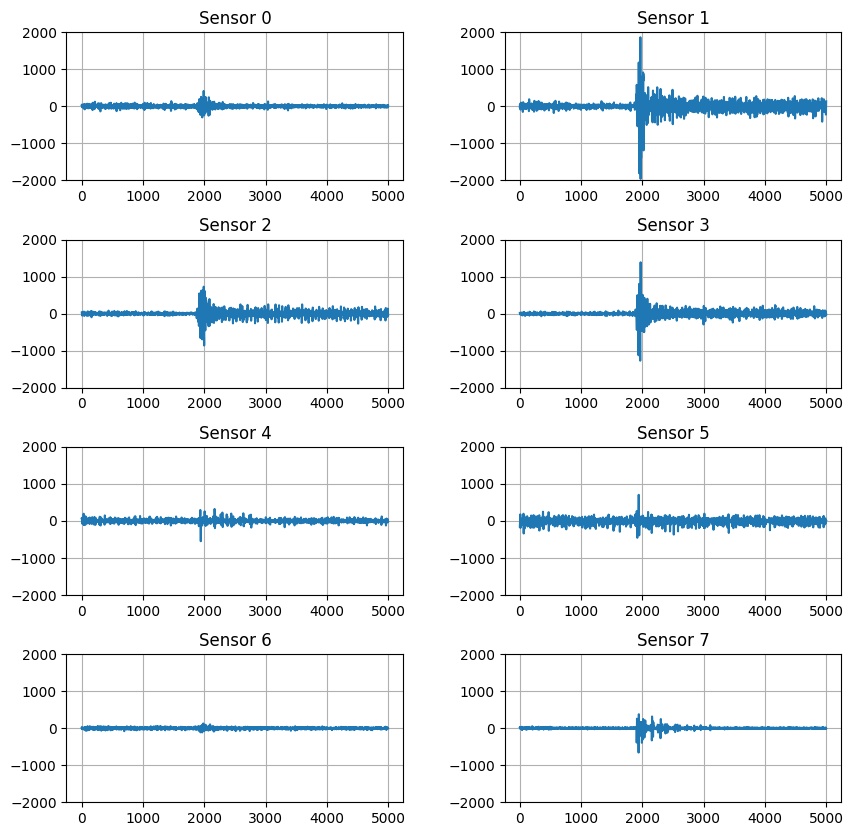

In [102]:
# example usage
T = 10000 # example ending time
size = 5000 # example size

time_window = get_time_window(
    X_train_raw,
    stop = T,
    size = size)

display(time_window.shape)

time_window_0 = time_window[0] # getting the first set of signals from the extracted time window
visualize_time_window(time_window[0])

## Time domain feature extraction

In [103]:
# features in the time domain from the project description
MAV = lambda x: np.mean(np.abs(x)) # mean absolute value
RMS = lambda x: np.mean(x**2)**0.5 # root mean square
VAR = lambda x: np.var(x, ddof=1) # variance
STD = lambda x: np.std(x, ddof=1) # standard deviation
ZC = lambda x: np.sum(x[:-1]*x[1:] < 0) # zero crossing
MPR = lambda x, sigma: np.mean(np.abs(x) > sigma) # myopulse percentage rate

# additional features in the time domain from the paper
MAA = lambda x: np.max(np.abs(x)) # maximum absolute amplitude
WL = lambda x: np.sum(abs(x[1:]-x[:-1])) # waveform length
SSC = lambda x: np.sum(-(x[2:]-x[1:-1])*(x[1:-1]-x[:-2]) > 0) # slope sign changes
WA = lambda x: np.sum(abs(x[1:]-x[:-1]) - STD(x) > 0) # wilson amplitude
MFL = lambda x: np.log((np.sum((x[1:]-x[:-1])**2))**0.5) # maximum fractal length
KRT = lambda x: sp.stats.kurtosis(x, bias=False) # kurtosis

# still to implement: hurst exponent, sample entropy

In [104]:
def get_feature_from_time_window(x, fun, **kwargs):
    # extract a time domain feature from an array x of d+1 dimensions
    # the time domain feature is fun applied to the last axis of x with keyword arguments kwargs
    # thus if x has shape (k1,...,kd,N) the return array has shape (k1,...,kd)
    # assumes that the time dimension is the last one
    return np.apply_along_axis(fun, -1, x, **kwargs)
    
def get_labels_from_time(y, time):
    # extracts the labels at a given time
    # assumes that the time dimension is the last one
    return y[...,time]

In [105]:
# dictionary collecting the various time domain feature functions
# keys are the function names, values are pairs with function handles and keyword arguments
time_domain_features = {
    'MAV':  (MAV,   {}),
    'RMS':  (RMS,   {}),
    'VAR':  (VAR,   {}),
    'STD':  (STD,   {}),
    'ZC':   (ZC,    {}),
    'MPR':  (MPR,   {'sigma': 0.3}), # change this when needed 
    'MAA':  (MAA,   {}),
    'WL':   (WL,    {}),
    'SSC':  (SSC,   {}),
    'WA':   (WA,    {}),
    'MFL':  (MFL,   {}),
    'KRT':  (KRT,   {}),
}

In [106]:
# regularly spaced endpoints for the time windows
size = 500
step = 100
stops = np.arange(size, X_train_raw.shape[-1]+1, step)
n_windows = len(stops)
n_features = len(time_domain_features)

X_train_windows = np.zeros((4, 8, n_windows, size))
Y_train = np.zeros((4, 51, n_windows))
for i in range(n_windows):
    X_train_windows[:,:,i,:] = get_time_window(X_train_raw, stops[i], size)
    Y_train[:, :, i] = Y_train_raw[:, :, stops[i]-1]
X_train_windows = X_train_windows.transpose(0,2,1,3)
Y_train = Y_train.transpose(0,2,1)

X_TD_train = np.zeros((4, n_windows, 8, n_features))
for key, j in zip(time_domain_features, range(n_features)):
    fun, kwargs = time_domain_features[key]
    X_TD_train[:, :, :, j] = get_feature_from_time_window(X_train_windows, fun, **kwargs)

# axis 0 is the experiment number
# axis 1 is the time window index
# axis 2 of X_train is the sensor index
# axis 2 of Y_train is the joint angle index
# axis 3 of X_train is the feature index
print('X_TD_train shape:', X_TD_train.shape)
print('Y_TD_train shape:', Y_train.shape)

X_TD_train shape: (4, 2296, 8, 12)
Y_TD_train shape: (4, 2296, 51)


In [109]:
# organize data in pandas dataframes for easier visualization
features_col_names = []
for i in range(8):
    features_col_names = features_col_names + [key + f'_{i}' for key in time_domain_features]

labels_col_names = []
for i in range(17):
    labels_col_names += [f'p_{i}', f'y_{i}', f'r_{i}'] # pitch, yaw, roll for each joint

X_TD_train_df = pd.DataFrame(
    X_TD_train.reshape(4*n_windows, 8*n_features),
    columns = features_col_names)

Y_train_df = pd.DataFrame(
    Y_train.reshape(4*n_windows, 51),
    columns = labels_col_names)

## Covariance matrix feature extraction

In [116]:
X_train_windows_flat = X_train_windows.reshape(4*n_windows, 8, size)
X_train_cov = pr.estimation.Covariances().fit_transform(X_train_windows_flat)